In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from src import config
from src.util import video2images, get_video_folder_paths, seleccionar_imagen, merge_datasets
from src.model import autolabel_images, predict_and_visualice
from src.dataset_processing import run_processing_dataset
import os
import json
import supervision as sv
import cv2
from src.data_augmentation import augment_dataset

In [56]:
# convertir los video en imagenes
# crear en el directorio raiz la ruta test\video_test\<sku del producto>
# colocar dentro un video y un archivo ontology.json con la ontología. 
video_path= get_video_folder_paths(config.VIDEO_TEST)[0]
print(video_path)

d:\Alexander\Go2Future\Autolabel_roboflow\test\video_test\7790040133488


In [57]:
# create image folder for each video folder
    
image_dir_path = os.path.join(config.IMAGE_TEST, os.path.basename(video_path))
if not os.path.exists(image_dir_path):
    os.mkdir(image_dir_path)

video2images(video_path, image_dir_path, frame_rate=200)

100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


In [146]:
# create dataset folder for each video folder
if not os.path.exists(config.DATA_TEST):
    os.mkdir(config.DATA_TEST)
    
dataset_dir_path = os.path.join(config.DATA_TEST, os.path.basename(video_path))
if not os.path.exists(dataset_dir_path):
    os.mkdir(dataset_dir_path)


In [147]:

autolabel_images(
            input_folder=image_dir_path,
            ontology=json.load(open(os.path.join(video_path, "ontology.json"))),
            box_threshold=0.35,
            text_threshold=0.25,
            output_folder=dataset_dir_path,
            extension=".jpg",
        )

Labeling d:\Alexander\Go2Future\Autolabel_roboflow\test\image_test\7790040133488\7790040133488_vertical_3-00005.jpg: 100%|██████████| 6/6 [02:32<00:00, 25.43s/it]


Labeled dataset created - ready for distillation.


In [151]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(dataset_dir_path, "train","labels")
IMAGES_DIRECTORY_PATH = os.path.join(dataset_dir_path, "train", "images")
DATA_YAML_PATH = os.path.join(dataset_dir_path, "data.yaml")

# Crear una clase DetetctionDatatset para YOLO
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

4

In [45]:
# create fuction to read a list of labels files .txt into a folder and erase empty files
# and remove images respect to the labels files

import os
def erase_empty_files(label_path, image_path):
    for lab_filename, image_filaname in zip(os.listdir(label_path), os.listdir(image_path)):
        if os.stat(os.path.join(label_path, lab_filename)).st_size == 0:
            os.remove(os.path.join(label_path, lab_filename))
            os.remove(os.path.join(image_path, image_filaname)
        )  
erase_empty_files(ANNOTATIONS_DIRECTORY_PATH ,IMAGES_DIRECTORY_PATH)    

In [150]:
run_processing_dataset(IMAGES_DIRECTORY_PATH, ANNOTATIONS_DIRECTORY_PATH, max_size=0.5, iou_threshold=0.1)


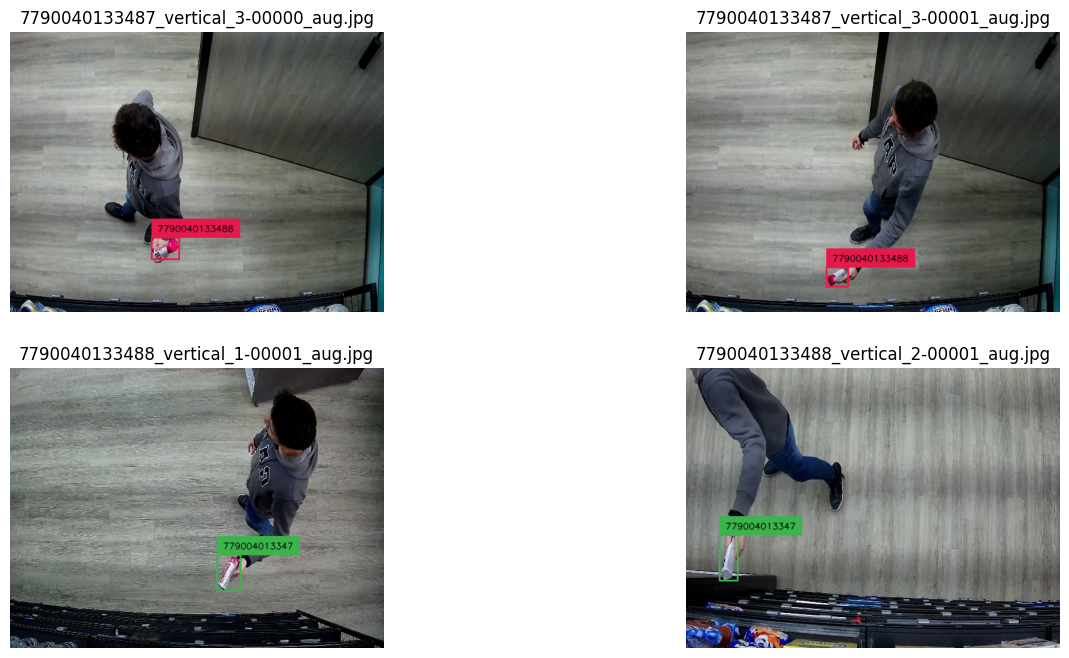

In [11]:
# Mostrar las anotaciones realizadas por el modelo base
SAMPLE_SIZE = 4
SAMPLE_GRID_SIZE = (2, 2)
SAMPLE_PLOT_SIZE = (16, 8)

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

### Probar autolabeling con una imagen

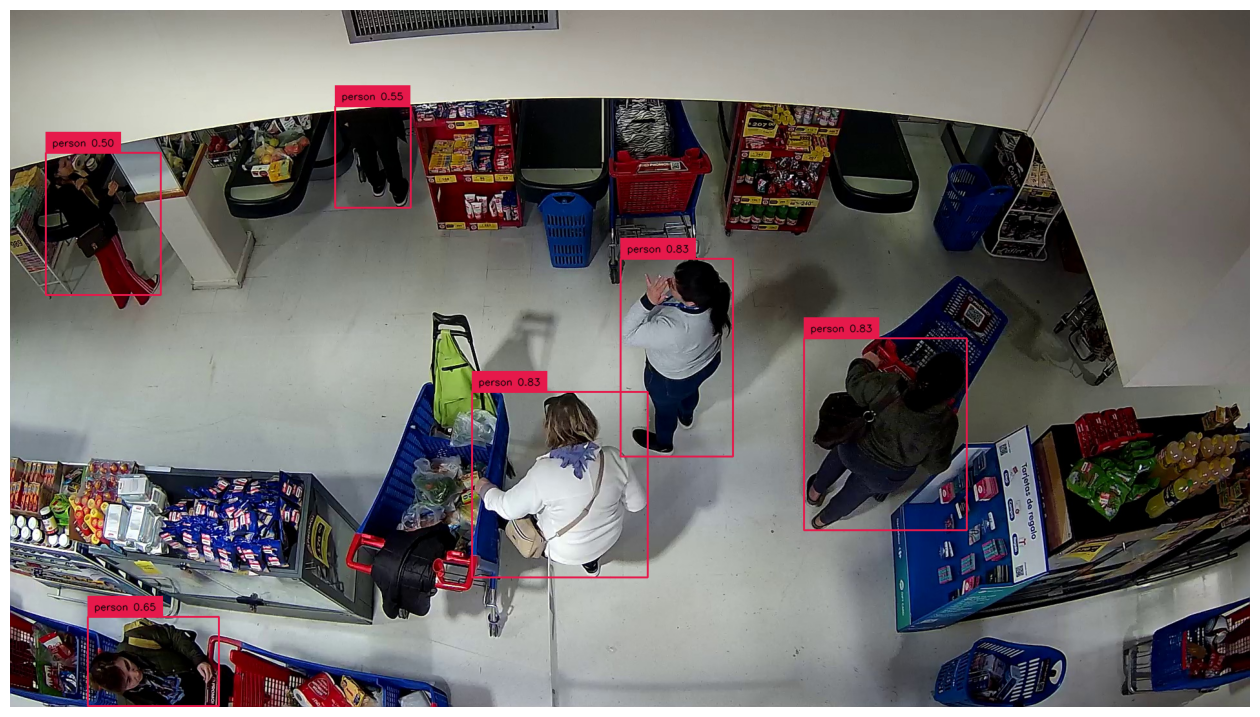

In [5]:
#image_path=os.path.join(config.IMAGE_DIR_PATH, "7790040133487/7790040133487_vertical_1-00000.jpg")
image_path=seleccionar_imagen()
predict_and_visualice(image_path, {"People": "person"})

### Hacer merge de los datasets individuales

In [3]:
# Unir datasets
    # crear el path a la carpeta de merged dataset dentro de dataset
output_path = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset")
    # obtener el nombre de cada dataset individual dentro de dataset
folders = os.listdir(config.DATASET_DIR_PATH)
    # Lista de paths de cada dataset individual
dataset_paths = [os.path.join(config.DATASET_DIR_PATH, folder) for folder in folders]
    # Hacer el merge
merge_datasets(dataset_paths, output_path)

INFO:root:Merging datasets...
100%|██████████| 2/2 [00:11<00:00,  5.51s/it]
INFO:root:Merged datasets created at d:\Alexander\Go2Future\Autolabel_roboflow\dataset\Merged_Dataset


['person', 'person']
['person']


# Corregir errores de etiquetado

In [9]:
# Procesar Merged_Dataset/train para eliminar errores de anotación
run_processing_dataset(
        os.path.join(output_path, "train", "images"),
        os.path.join(output_path, "train", "labels"),
    )
    # Procesar Merged_Dataset/valid para eliminar errores de anotación
run_processing_dataset(
        os.path.join(output_path, "valid", "images"),
        os.path.join(output_path, "valid", "labels"),
    )

removed large
removed overlaping
removed empty
removed large
removed overlaping
removed empty


## Data augmentation

In [14]:
dataset_path=os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset")
augmented_dataset_path=os.path.join(config.DATASET_DIR_PATH, "Augmented_Dataset")
# creating aumented datased directory
if not os.path.exists(augmented_dataset_path):
    os.makedirs(augmented_dataset_path)

augment_dataset(dataset_path, augmented_dataset_path, augmented_for=5)

INFO:root:Transforming data.yaml ...
INFO:root:Generating train augmented images ...
  0%|          | 12/2953 [00:00<03:58, 12.32it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  1%|          | 17/2953 [00:01<03:17, 14.88it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  1%|          | 22/2953 [00:01<02:48, 17.39it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  1%|          | 29/2953 [00:02<02:57, 16.49it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  1%|▏         | 41/2953 [00:02<03:47, 12.81it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  2%|▏         | 46/2953 [00:03<02:54, 16.62it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  2%|▏         | 58/2953 [00:04<03:20, 14.43it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  3%|▎         | 74/2953 [00:05<03:34, 13.42it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  3%|▎         | 101/2953 [00:07<03:18, 14.34it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  4%|▎         | 106/2953 [00:07<02:55, 16.26it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  4%|▍         | 121/2953 [00:09<03:09, 14.94it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  4%|▍         | 131/2953 [00:10<04:02, 11.64it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  5%|▍         | 141/2953 [00:10<04:10, 11.21it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  5%|▍         | 144/2953 [00:11<03:33, 13.15it/s]

label file is empty
label file is empty
label file is empty


  6%|▌         | 166/2953 [00:13<03:49, 12.15it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  6%|▌         | 184/2953 [00:14<03:43, 12.40it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  7%|▋         | 194/2953 [00:15<03:31, 13.02it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  7%|▋         | 206/2953 [00:16<03:47, 12.07it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  7%|▋         | 218/2953 [00:17<03:36, 12.61it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  8%|▊         | 228/2953 [00:18<03:29, 13.03it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  8%|▊         | 234/2953 [00:18<03:25, 13.21it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  9%|▊         | 258/2953 [00:20<03:11, 14.08it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  9%|▉         | 271/2953 [00:22<03:28, 12.84it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


  9%|▉         | 275/2953 [00:22<03:27, 12.89it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 10%|▉         | 281/2953 [00:22<03:30, 12.68it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 10%|▉         | 293/2953 [00:23<03:31, 12.56it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 10%|█         | 299/2953 [00:24<03:25, 12.93it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 11%|█         | 317/2953 [00:25<03:28, 12.64it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 11%|█▏        | 335/2953 [00:27<03:03, 14.26it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 12%|█▏        | 341/2953 [00:27<03:06, 13.99it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 12%|█▏        | 352/2953 [00:28<03:14, 13.37it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 13%|█▎        | 372/2953 [00:30<03:28, 12.37it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 13%|█▎        | 381/2953 [00:31<03:06, 13.79it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 13%|█▎        | 388/2953 [00:31<03:07, 13.72it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 14%|█▎        | 402/2953 [00:32<03:07, 13.62it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 14%|█▍        | 416/2953 [00:33<03:20, 12.66it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 14%|█▍        | 421/2953 [00:34<02:47, 15.07it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 15%|█▍        | 431/2953 [00:35<03:05, 13.63it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 15%|█▌        | 443/2953 [00:35<02:57, 14.15it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 16%|█▌        | 468/2953 [00:37<02:53, 14.31it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 16%|█▌        | 477/2953 [00:38<02:53, 14.31it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 16%|█▋        | 485/2953 [00:39<03:10, 12.95it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 17%|█▋        | 489/2953 [00:39<02:51, 14.34it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 17%|█▋        | 499/2953 [00:40<02:58, 13.75it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 17%|█▋        | 503/2953 [00:40<03:07, 13.03it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 17%|█▋        | 509/2953 [00:40<02:29, 16.35it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 18%|█▊        | 543/2953 [00:43<03:06, 12.90it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 19%|█▉        | 561/2953 [00:45<02:52, 13.87it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 19%|█▉        | 573/2953 [00:46<03:08, 12.65it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 20%|█▉        | 581/2953 [00:47<02:59, 13.20it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 20%|█▉        | 584/2953 [00:47<02:45, 14.29it/s]

label file is empty


 20%|██        | 598/2953 [00:48<03:07, 12.58it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 21%|██        | 614/2953 [00:49<03:00, 12.95it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 21%|██        | 620/2953 [00:50<03:00, 12.95it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 21%|██        | 626/2953 [00:50<02:51, 13.53it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 22%|██▏       | 641/2953 [00:51<02:57, 13.05it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 22%|██▏       | 656/2953 [00:53<02:58, 12.85it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 22%|██▏       | 662/2953 [00:53<02:58, 12.82it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 23%|██▎       | 670/2953 [00:54<02:55, 12.99it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 23%|██▎       | 678/2953 [00:54<02:46, 13.64it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 23%|██▎       | 682/2953 [00:55<02:45, 13.71it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 23%|██▎       | 690/2953 [00:55<02:48, 13.43it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 24%|██▎       | 698/2953 [00:56<02:54, 12.95it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 24%|██▍       | 704/2953 [00:56<02:41, 13.94it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 24%|██▍       | 716/2953 [00:57<02:56, 12.65it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 24%|██▍       | 722/2953 [00:58<02:36, 14.27it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 25%|██▍       | 729/2953 [00:58<02:26, 15.20it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 25%|██▍       | 733/2953 [00:59<02:37, 14.07it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 25%|██▌       | 743/2953 [00:59<02:51, 12.91it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 25%|██▌       | 747/2953 [01:00<02:47, 13.17it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 26%|██▌       | 757/2953 [01:01<02:33, 14.33it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 26%|██▌       | 762/2953 [01:01<02:36, 14.01it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 26%|██▌       | 769/2953 [01:01<02:36, 13.95it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 26%|██▌       | 774/2953 [01:02<02:29, 14.56it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 26%|██▋       | 779/2953 [01:02<02:36, 13.86it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 27%|██▋       | 783/2953 [01:02<02:34, 14.09it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 27%|██▋       | 789/2953 [01:03<02:31, 14.29it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 27%|██▋       | 798/2953 [01:04<02:35, 13.89it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 27%|██▋       | 805/2953 [01:04<02:28, 14.43it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 27%|██▋       | 808/2953 [01:04<02:18, 15.53it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 28%|██▊       | 818/2953 [01:05<02:15, 15.77it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 28%|██▊       | 822/2953 [01:05<02:24, 14.78it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 28%|██▊       | 829/2953 [01:06<02:14, 15.79it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 28%|██▊       | 835/2953 [01:06<02:25, 14.58it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 28%|██▊       | 841/2953 [01:07<02:37, 13.43it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 29%|██▊       | 843/2953 [01:07<02:30, 14.03it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 29%|██▊       | 847/2953 [01:07<02:35, 13.50it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 29%|██▉       | 853/2953 [01:07<02:09, 16.24it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 29%|██▉       | 858/2953 [01:08<02:03, 16.99it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 29%|██▉       | 863/2953 [01:08<02:09, 16.18it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 30%|██▉       | 875/2953 [01:09<02:46, 12.48it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 30%|██▉       | 885/2953 [01:10<02:24, 14.29it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 30%|███       | 896/2953 [01:11<02:22, 14.46it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 30%|███       | 900/2953 [01:11<02:28, 13.79it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 31%|███       | 908/2953 [01:12<02:44, 12.43it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 31%|███▏      | 924/2953 [01:13<02:31, 13.38it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 32%|███▏      | 936/2953 [01:14<02:36, 12.87it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 32%|███▏      | 942/2953 [01:14<02:16, 14.78it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 32%|███▏      | 948/2953 [01:15<02:26, 13.68it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 33%|███▎      | 973/2953 [01:17<02:15, 14.65it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 33%|███▎      | 979/2953 [01:18<02:31, 13.02it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 33%|███▎      | 988/2953 [01:18<02:24, 13.62it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 34%|███▍      | 1004/2953 [01:20<02:39, 12.25it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 37%|███▋      | 1096/2953 [01:28<02:19, 13.28it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 72%|███████▏  | 2129/2953 [03:01<01:12, 11.33it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 84%|████████▎ | 2471/2953 [03:36<00:34, 13.82it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 84%|████████▍ | 2481/2953 [03:36<00:27, 17.14it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 84%|████████▍ | 2489/2953 [03:37<00:20, 22.41it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 85%|████████▌ | 2523/2953 [03:39<00:33, 12.69it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 86%|████████▌ | 2529/2953 [03:40<00:30, 13.95it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 86%|████████▌ | 2538/2953 [03:40<00:29, 14.26it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 86%|████████▌ | 2546/2953 [03:41<00:30, 13.23it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 86%|████████▋ | 2552/2953 [03:41<00:21, 18.95it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 90%|████████▉ | 2655/2953 [03:50<00:23, 12.92it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 91%|█████████▏| 2699/2953 [03:54<00:21, 11.74it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 92%|█████████▏| 2704/2953 [03:55<00:17, 13.88it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 92%|█████████▏| 2709/2953 [03:55<00:16, 15.07it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 92%|█████████▏| 2725/2953 [03:56<00:15, 14.76it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 93%|█████████▎| 2734/2953 [03:57<00:14, 15.56it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


 93%|█████████▎| 2742/2953 [03:57<00:15, 14.01it/s]

label file is empty
label file is empty
label file is empty
label file is empty
label file is empty


100%|██████████| 2953/2953 [04:16<00:00, 11.51it/s]
INFO:root:Data train augmentation ended ...
INFO:root:Addjusting validation data  ...
 23%|██▎       | 164/723 [00:02<00:08, 66.25it/s]

label file is empty


 26%|██▌       | 185/723 [00:02<00:08, 64.69it/s]

label file is empty


 28%|██▊       | 200/723 [00:03<00:07, 67.03it/s]

label file is empty


 65%|██████▌   | 472/723 [00:07<00:03, 72.37it/s]

label file is empty
label file is empty


 86%|████████▋ | 624/723 [00:09<00:01, 71.45it/s]

label file is empty
label file is empty
label file is empty
label file is empty


 94%|█████████▍| 679/723 [00:10<00:00, 70.16it/s]

label file is empty


100%|██████████| 723/723 [00:11<00:00, 65.62it/s]
INFO:root:Data augmentation ended ...


## Llevar todas las anotaciones a un video

In [3]:
ANNOTATIONS_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/train/labels")
IMAGES_DIRECTORY_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/train/images")
DATA_YAML_PATH = os.path.join(config.DATASET_DIR_PATH, "Merged_Dataset/data.yaml")

# Crear una clase DetetctionDatatset para YOLO
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

435

In [4]:
image_names = list(dataset.images.keys())

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

In [14]:
# Especificar la ruta del video de salida y la velocidad de fotogramas
video_name =os.path.join(config.DATASET_DIR_PATH, "anotaciones.mp4") 
fps = 2

# Obtener la altura y el ancho de la primera imagen
height, width, layers = images[0].shape

# Crear el objeto VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, fps, (width,height))

# Agregar cada imagen al video
for image in images:
    video.write(image)

# Liberar el objeto VideoWriter y cerrar la ventana
cv2.destroyAllWindows()
video.release()

## Salvar imagenes anotadas para visualización

In [5]:
# Crear una carpeta para almacenar las imágenes si no existe
anotate_images=os.path.join(config.DATASET_DIR_PATH, "imagenes_anotadas")
if not os.path.exists(anotate_images):
    os.makedirs(anotate_images)


# Guardar cada imagen como un archivo individual
for idx, image in enumerate(images):
    output_path = os.path.join(anotate_images, f"imagen_{idx+1}.png")
    cv2.imwrite(output_path, image)

print("Imágenes guardadas exitosamente.")

Imágenes guardadas exitosamente.
